In [86]:
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, roc_auc_score, confusion_matrix, matthews_corrcoef, cohen_kappa_score, f1_score, balanced_accuracy_score
import numpy as np

def compute_auc_roc_pr_metrics(y_true: np.ndarray, y_pred: np.ndarray, num_thresholds: int = 100):
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    precision = np.zeros(num_thresholds)
    recall = np.zeros(num_thresholds)
    fpr = np.zeros(num_thresholds)
    tpr = np.zeros(num_thresholds)

    for i, t in enumerate(thresholds):
        y_pred_bin = (y_pred >= t).astype(int)

        TP = np.sum((y_true == 1) & (y_pred_bin == 1))
        FP = np.sum((y_true == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true == 1) & (y_pred_bin == 0))
        TN = np.sum((y_true == 0) & (y_pred_bin == 0))

        precision[i] = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall[i] = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        fpr[i] = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        tpr[i] = recall[i]  # TPR is the same as recall

    return precision, recall, fpr, tpr

# Helper functions
def compute_metrics(true_vals_binary, pred_probabilities, threshold=0.5):
    """Compute all classification metrics."""
    binary_preds = (pred_probabilities > threshold).astype(int)
    cm = confusion_matrix(true_vals_binary, binary_preds)
    
    TN = FP = FN = TP = -1
    if cm.shape == (2,2):
        TN, FP, FN, TP = cm.ravel()
    
    acc = accuracy_score(true_vals_binary, binary_preds)
    mcc = matthews_corrcoef(true_vals_binary, binary_preds)
    cohens_kappa_gt = cohen_kappa_score(true_vals_binary, binary_preds)
    roc_auc = roc_auc_score(true_vals_binary, pred_probabilities)
    
    precision_precise, recall_precise, _ = precision_recall_curve(true_vals_binary, pred_probabilities)
    pr_auc = auc(recall_precise, precision_precise)
    
    precision_100, recall_100, fpr_100, tpr_100 = compute_auc_roc_pr_metrics(true_vals_binary, pred_probabilities, num_thresholds=100)
    
    return {
        "accuracy": acc,
        "TN": TN,
        "FP": FP,
        "FN": FN,
        "TP": TP,
        "Precision (100 thresholds)": precision_100,
        "Recall (100 thresholds)": recall_100,
        "FPR (100 thresholds)": fpr_100,
        "TPR (100 thresholds)": tpr_100,
        "mcc": mcc,
        "cohens_kappa_gt": cohens_kappa_gt,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc
    }

from sklearn.metrics import f1_score

def find_best_threshold(y_true, y_pred_probs, metric='f1', num_thresholds=100):
    thresholds = np.linspace(0, 1, num_thresholds)
    best_thresh = 0.5
    best_score = -np.inf
    
    for t in thresholds:
        y_pred_bin = (y_pred_probs >= t).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred_bin)
        elif metric == 'accuracy':
            score = accuracy_score(y_true, y_pred_bin)
        elif metric == 'mcc':
            score = matthews_corrcoef(y_true, y_pred_bin)
        else:
            raise ValueError(f"Unsupported metric: {metric}")
        
        if score > best_score:
            best_score = score
            best_thresh = t
            
    return best_thresh, best_score

In [87]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    matthews_corrcoef,
    cohen_kappa_score,
    f1_score
)

# -------------------------
# Core helpers
# -------------------------

def confusion_from_threshold(y_true, y_pred, threshold):
    y_bin = (y_pred >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_bin).ravel()
    return tn, fp, fn, tp


def compute_metrics(y_true, y_pred, threshold=0.5):
    tn, fp, fn, tp = confusion_from_threshold(y_true, y_pred, threshold)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_pred)
    pr_auc = auc(recall_curve, precision_curve)

    return {
        "accuracy": accuracy_score(y_true, (y_pred >= threshold).astype(int)),
        "roc_auc": roc_auc_score(y_true, y_pred),
        "pr_auc": pr_auc,
        "precision": precision,
        "recall": recall,
        "specificity": specificity,
        "f1_score": f1,
        "mcc": matthews_corrcoef(y_true, (y_pred >= threshold).astype(int)),
        "cohens_kappa": cohen_kappa_score(y_true, (y_pred >= threshold).astype(int)),
    }


def find_best_threshold(y_true, y_pred, metric="accuracy", num_thresholds=100):
    thresholds = np.linspace(0.0, 1.0, num_thresholds)
    best_t = 0.5
    best_score = -np.inf
    
    for t in thresholds:
        y_bin = (y_pred >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_bin).ravel()

        if metric == "accuracy":
            score = accuracy_score(y_true, y_bin)
        elif metric == "f1":
            score = f1_score(y_true, y_bin)
        elif metric == "mcc":
            score = matthews_corrcoef(y_true, y_bin)
        elif metric == "balanced_acc":
            score = (tn/(tn+fp) + tp/(tp+fn)) / 2.0
        else:
            raise ValueError(f"Unsupported metric: {metric}")

        if score > best_score:
            best_score = score
            best_t = t

    return best_t

In [90]:
def mean_and_ci(values, confidence=0.95):
    values = np.asarray(values)
    mean = values.mean()
    stderr = values.std(ddof=1) / np.sqrt(len(values))
    margin = 1.96 * stderr  # 95% CI
    return mean, margin, stderr
    
from pathlib import Path

def evaluate_cv_folds(results_dir, n_folds=10, threshold_metric="accuracy", final=False):
    per_fold_metrics_normal = []
    per_fold_metrics_optimal = []

    if final:
        n_folds = 1
        
    for fold in range(n_folds):
        if final:
            fold = -1
        data = np.load(Path(results_dir) / f"val_preds_fold_{fold}.npz")
        y_true = data["y_val"]
        y_pred = data["y_hat_val"]

        best_t = find_best_threshold(y_true, y_pred, metric=threshold_metric)

        metrics_normal = compute_metrics(y_true, y_pred, threshold=0.5)
        metrics_optimal = compute_metrics(y_true, y_pred, threshold=best_t)

        per_fold_metrics_normal.append(metrics_normal)
        per_fold_metrics_optimal.append(metrics_optimal)

    metric_names = [
        "accuracy",
        "roc_auc",
        "pr_auc",
        "precision",
        "recall",
        "specificity",
        "f1_score",
        "mcc",
        "cohens_kappa",
    ]

    rows = []
    for name in metric_names:        
        normal_vals = [m[name] for m in per_fold_metrics_normal]
        optimal_vals = [m[name] for m in per_fold_metrics_optimal]

        mean_n, ci_n, stderr_n = mean_and_ci(normal_vals)
        mean_o, ci_o, stderr_o = mean_and_ci(optimal_vals)

        if not final:
            rows.append({
                "metric": name,
                "normal (mean)": mean_n,
                "normal (±)": stderr_n,
                "optimal (mean)": mean_o,
                "optimal (±)": stderr_o,
                "Δ mean": mean_o - mean_n,
            })
        else:
            rows.append({
                "metric": name,
                "normal (mean)": mean_n,
                "optimal (mean)": mean_o,
                "Δ mean": mean_o - mean_n,
            })

    df = pd.DataFrame(rows)
    pd.set_option("display.float_format", lambda x: f"{x:.3f}")
    return df


In [91]:
df = evaluate_cv_folds(
    results_dir="./results/training_run_20251217_224656/normal_full",
    n_folds=10,
    threshold_metric="balanced_acc",
)

print(df)

         metric  normal (mean)  normal (±)  optimal (mean)  optimal (±)  \
0      accuracy          0.710       0.013           0.731        0.010   
1       roc_auc          0.788       0.012           0.788        0.012   
2        pr_auc          0.779       0.018           0.779        0.018   
3     precision          0.683       0.015           0.723        0.013   
4        recall          0.796       0.017           0.756        0.025   
5   specificity          0.623       0.030           0.706        0.022   
6      f1_score          0.733       0.010           0.736        0.012   
7           mcc          0.429       0.024           0.467        0.020   
8  cohens_kappa          0.420       0.026           0.462        0.020   

   Δ mean  
0   0.021  
1   0.000  
2   0.000  
3   0.040  
4  -0.041  
5   0.083  
6   0.003  
7   0.038  
8   0.043  


In [109]:
def visual_model_name(name, crop_mappings={"Hm":"Temporal","Vert":"Vertical","Od":"OD"}):
    def capitalize_part(part):
        if part == "CLAHE":
            return "CLAHE"
        return part.capitalize()

    result = []

    preprocessing, cropping = name.rsplit("_", 1)

    # Handle compound preprocessing like gray_CLAHE
    preprocessing_parts = preprocessing.split("_")
    preprocessing_formatted = "_".join(capitalize_part(p) for p in preprocessing_parts)

    cropping_formatted = cropping.capitalize()
    
    if cropping_formatted in crop_mappings.keys():
        cropping_formatted = crop_mappings[cropping_formatted]
        
    result.append(f"{preprocessing_formatted} / {cropping_formatted}")

    return result

def compute_roc_auc_fold_separate(model_name, results_dir, n_folds=10):
    per_fold_metrics = []
        
    for fold in range(n_folds):

        data = np.load(Path(results_dir) / f"val_preds_fold_{fold}.npz")
        y_true = data["y_val"]
        y_pred = data["y_hat_val"]

        metrics_normal = compute_metrics(y_true, y_pred, threshold=0.5)
        per_fold_metrics.append((model_name, fold, metrics_normal['roc_auc']))
        
    return per_fold_metrics

from pathlib import Path
BASE_DIR = Path("./results/training_run_20251217_224656")

model_dirs = sorted([
    p for p in BASE_DIR.iterdir()
    if p.is_dir() and not p.name.endswith("_FINAL")
])

import pandas as pd
all_cv_results = []
for model_dir in model_dirs:
    model_name = str(model_dir).split('/')[-1]
    for tup in compute_roc_auc_fold_separate(model_name, model_dir, 10):
        all_cv_results.append(tup)

all_cv_roc_df = pd.DataFrame(all_cv_results, columns=['model', 'fold', 'roc_auc']) 

# 1. Filter for the specific models
target_models = ['edges_full', 'edges_hm', 'edges_vert', 'edges_od']
filtered_df = all_cv_roc_df[all_cv_roc_df['model'].isin(target_models)]

# 2. Group by model and calculate the mean
mean_roc_auc = filtered_df.groupby('model')['roc_auc'].mean().sort_values(ascending=False)

print(mean_roc_auc)

model
edges_hm     0.706
edges_vert   0.705
edges_full   0.678
edges_od     0.671
Name: roc_auc, dtype: float64


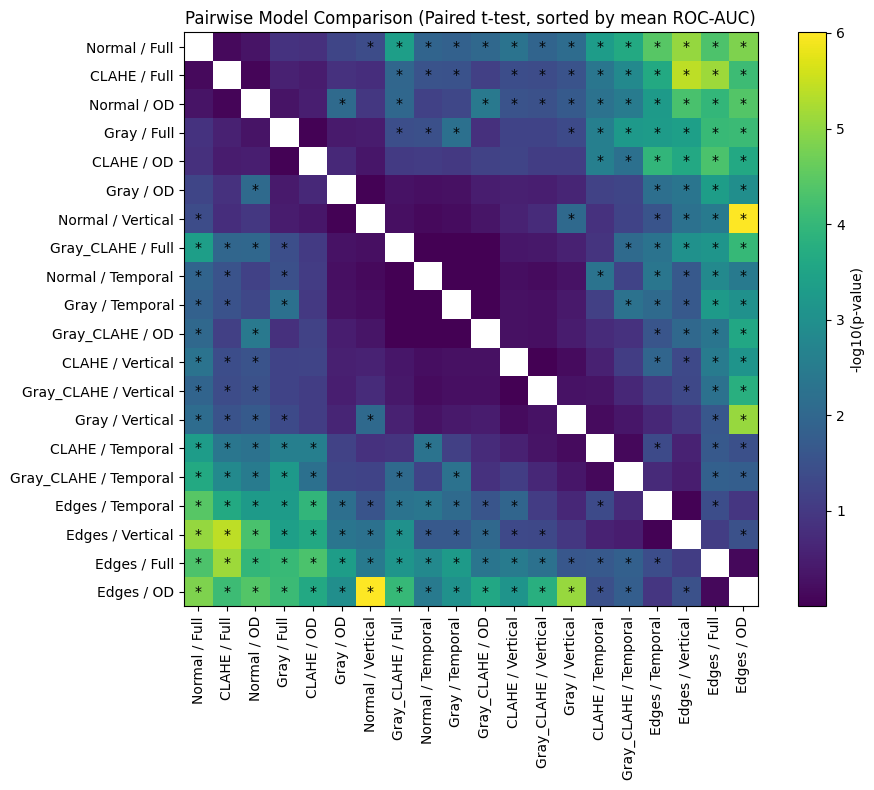

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# Pivot to shape: rows = folds, columns = models
pivot = all_cv_roc_df.pivot(index="fold", columns="model", values="roc_auc")

# Compute mean ROC-AUC per model and sort (best first)
model_means = pivot.mean().sort_values(ascending=False)
sorted_models = model_means.index.tolist()
visual_labels = [visual_model_name(m)[0] for m in sorted_models]

# Initialize p-value matrix
pval_matrix = pd.DataFrame(
    np.ones((len(sorted_models), len(sorted_models))),
    index=sorted_models,
    columns=sorted_models
)

# Fill p-value matrix using paired t-tests
for i, m1 in enumerate(sorted_models):
    for j, m2 in enumerate(sorted_models):
        if i < j:
            stat, p = ttest_rel(pivot[m1], pivot[m2])
            pval_matrix.loc[m1, m2] = p
            pval_matrix.loc[m2, m1] = p

# Convert p-values to -log10(p)
log_pvals = -np.log10(pval_matrix)

# Mask diagonal
mask = np.eye(len(log_pvals), dtype=bool)
log_pvals_masked = log_pvals.mask(mask)

# Plot heatmap
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(log_pvals_masked.values)

# Axis labels
ax.set_xticks(range(len(sorted_models)))
ax.set_yticks(range(len(sorted_models)))
ax.set_xticklabels(visual_labels, rotation=90)
ax.set_yticklabels(visual_labels)

# Colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("-log10(p-value)")

# Mark significance threshold (p < 0.05)
sig_thresh = -np.log10(0.05)
for i in range(len(sorted_models)):
    for j in range(len(sorted_models)):
        if i != j and log_pvals.iloc[i, j] >= sig_thresh:
            ax.text(j, i, "*", ha="center", va="center", color="black")

ax.set_title("Pairwise Model Comparison (Paired t-test, sorted by mean ROC-AUC)")
plt.tight_layout()
plt.show()


In [93]:
from pathlib import Path

BASE_DIR = Path("./results/training_run_20251217_224656")
BASE_DIR_TEST = Path("./results/training_run_20251217_224656_FINAL")
model_dirs = sorted([
    p for p in BASE_DIR.iterdir()
    if p.is_dir() and not p.name.endswith("_FINAL")
])
test_model_dirs = sorted([
    p for p in BASE_DIR_TEST.iterdir()
    if p.is_dir()
])

import pandas as pd

all_cv_results = []
all_cv_results_final = []

for model_dir in model_dirs:
    df = evaluate_cv_folds(
        results_dir=str(model_dir),
        n_folds=10,
        threshold_metric="balanced_acc",
        final=False
    )
    df["model"] = model_dir.name
    all_cv_results.append(df)

for model_dir in test_model_dirs:
    df = evaluate_cv_folds(
        results_dir=str(model_dir),
        n_folds=1,
        threshold_metric="balanced_acc",
        final=True
    )
    df["model"] = model_dir.name
    all_cv_results_final.append(df)

cv_results = pd.concat(all_cv_results, ignore_index=True)
cv_results_final = pd.concat(all_cv_results_final, ignore_index=True)

print(cv_results)

/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210

           metric  normal (mean)  normal (±)  optimal (mean)  optimal (±)  \
0        accuracy          0.684       0.008           0.722        0.007   
1         roc_auc          0.785       0.010           0.785        0.010   
2          pr_auc          0.781       0.015           0.781        0.015   
3       precision          0.659       0.007           0.712        0.026   
4          recall          0.765       0.027           0.793        0.042   
..            ...            ...         ...             ...          ...   
175        recall          0.665       0.035           0.758        0.040   
176   specificity          0.683       0.017           0.670        0.035   
177      f1_score          0.668       0.027           0.722        0.020   
178           mcc          0.350       0.043           0.439        0.032   
179  cohens_kappa          0.348       0.043           0.427        0.032   

     Δ mean        model  
0     0.038   CLAHE_full  
1     0.000   CLAHE_f

/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/sgroote/tf-venv/lib/python3.9/site-packages/numpy/_core/_methods.py:210

In [131]:
import numpy as np
import pandas as pd
from pathlib import Path

results_base = Path("./results/training_run_20251217_224656/")
model_dirs = [d for d in results_base.iterdir() if d.is_dir()]

summary_rows = []

for model_dir in model_dirs:
    df = evaluate_cv_folds(model_dir, n_folds=10, threshold_metric="balanced_acc", final=False)
    
    metrics = df.set_index("metric")
    
    def format_mean_ci(metric_name):
        mean = metrics.loc[metric_name, "normal (mean)"]
        ci = metrics.loc[metric_name, "normal (±)"]
        return f"{mean:.3f} ± {ci:.3f}"
    
    summary_rows.append({
        "model": visual_model_name(model_dir.name)[0],
        "ROC-AUC": format_mean_ci("roc_auc"),
        "F1": format_mean_ci("f1_score"),
        "Sensitivity": format_mean_ci("recall"),
        "Specificity": format_mean_ci("specificity")
    })

summary_df = pd.DataFrame(summary_rows)

# Top 5 models by normal ROC-AUC
top5_df = summary_df.sort_values("ROC-AUC", key=lambda x: x.str.split(" ±").str[0].astype(float), ascending=False).head(5)

# Convert to LaTeX
latex_table = top5_df.to_latex(index=False, escape=False)
print(latex_table)


\begin{tabular}{lllll}
\toprule
model & ROC-AUC & F1 & Sensitivity & Specificity \\
\midrule
Normal / Full & 0.788 ± 0.012 & 0.733 ± 0.010 & 0.796 ± 0.017 & 0.623 ± 0.030 \\
CLAHE / Full & 0.785 ± 0.010 & 0.706 ± 0.011 & 0.765 ± 0.027 & 0.604 ± 0.018 \\
Normal / OD & 0.783 ± 0.014 & 0.699 ± 0.014 & 0.701 ± 0.023 & 0.698 ± 0.026 \\
Gray / Full & 0.774 ± 0.012 & 0.709 ± 0.011 & 0.770 ± 0.024 & 0.600 ± 0.029 \\
CLAHE / OD & 0.773 ± 0.012 & 0.670 ± 0.013 & 0.651 ± 0.026 & 0.713 ± 0.033 \\
\bottomrule
\end{tabular}



In [125]:
final_results_base = Path("./results/training_run_20251217_224656_FINAL/")
final_model_dirs = [d for d in results_base.iterdir() if d.is_dir()]

In [126]:
summary_optimal = (
    cv_results
    .pivot_table(
        index="model",
        columns="metric",
        values="optimal (mean)"
    )
    .sort_index()
)
# print(summary_optimal)
latex_code = summary_optimal[["f1_score","roc_auc","specificity","recall"]].head(5).to_latex(index=False, float_format="%.3f")
print(latex_code)


\begin{tabular}{rrrr}
\toprule
f1_score & roc_auc & specificity & recall \\
\midrule
0.738 & 0.785 & 0.652 & 0.793 \\
0.675 & 0.725 & 0.666 & 0.699 \\
0.704 & 0.773 & 0.717 & 0.709 \\
0.703 & 0.741 & 0.665 & 0.732 \\
0.667 & 0.678 & 0.577 & 0.717 \\
\bottomrule
\end{tabular}



In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Filter ROC-AUC rows
roc_df = cv_results[cv_results["metric"] == "roc_auc"].copy()
roc_df_final = cv_results_final[cv_results["metric"] == "roc_auc"].copy()

# Use optimal threshold results
roc_df = roc_df[[
    "model",
    "optimal (mean)",
    "optimal (±)"
]].rename(columns={
    "optimal (mean)": "mean",
    "optimal (±)": "ci"
})

roc_df_final = roc_df_final[[
    "model",
    "optimal (mean)",
]].rename(columns={
    "optimal (mean)": "mean"
})

# Sort by performance (descending)
roc_df = roc_df.sort_values("mean", ascending=True)  # For horizontal bar, smaller y-values on bottom

print(roc_df['mean'].mean())
print(roc_df)

0.7423715538847118
               model  mean    ci
55          edges_od 0.671 0.023
37        edges_full 0.678 0.016
64        edges_vert 0.705 0.013
46          edges_hm 0.706 0.014
82     gray_CLAHE_hm 0.721 0.018
10          CLAHE_hm 0.725 0.016
136        gray_vert 0.735 0.025
100  gray_CLAHE_vert 0.741 0.022
28        CLAHE_vert 0.741 0.022
91     gray_CLAHE_od 0.750 0.020
118          gray_hm 0.750 0.017
154        normal_hm 0.751 0.015
73   gray_CLAHE_full 0.751 0.015
172      normal_vert 0.759 0.022
127          gray_od 0.760 0.017
19          CLAHE_od 0.773 0.012
109        gray_full 0.774 0.012
163        normal_od 0.783 0.014
1         CLAHE_full 0.785 0.010
145      normal_full 0.788 0.012


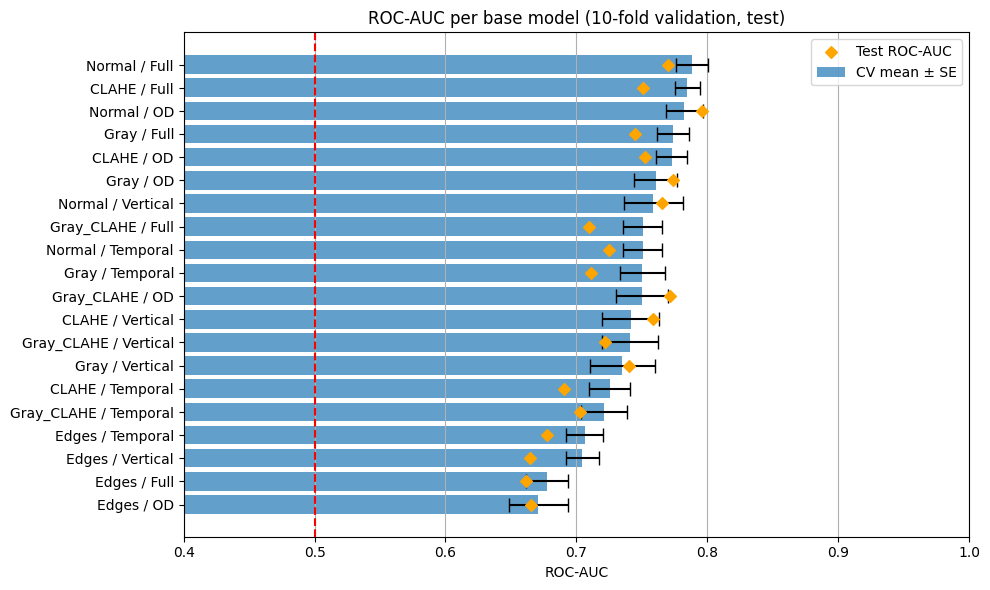

In [121]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure same ordering
roc_df = roc_df.reset_index(drop=True)
y_labels = roc_df["model"].apply(lambda name: visual_model_name(name, crop_mappings={"Hm":"Temporal","Vert":"Vertical","Od":"OD"})[0])

# Map final test means by model
final_mean_map = roc_df_final.set_index("model")["mean"]

# Get final means aligned to roc_df order
final_means_aligned = roc_df["model"].map(final_mean_map)

plt.figure(figsize=(10, 6))

y = np.arange(len(roc_df))

# Validation bars (mean ± CI)
plt.barh(
    y,
    roc_df["mean"],
    xerr=roc_df["ci"],
    capsize=5,
    alpha=0.7,
    label="CV mean ± SE"
)

# Overlay final test scores as points
plt.scatter(
    final_means_aligned,
    y,
    marker="D",
    color="orange",
    zorder=3,
    label="Test ROC-AUC"
)

plt.xlim(0.4, 1.0)
plt.yticks(y, y_labels)
plt.xlabel("ROC-AUC")
plt.title("ROC-AUC per base model (10-fold validation, test)")
plt.grid(axis="x")
plt.axvline(0.5, linestyle="dashed", color="red")

plt.legend()
plt.tight_layout()
plt.show()
